In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from datetime import datetime
from scipy import stats
import statsmodels.api as sm
plt.style.use("seaborn-v0_8")

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 11 Sector ETFs + VIX & 10‑yr yield for validation
sector_tickers = [
    "XLK", "XLF", "XLV", "XLE", "XLI", "XLY",
    "XLP", "XLB", "XLU"#, "^GSPC"
]
extra_tickers = ["^VIX", "^TNX", "LQD"] #"SP500BDT"]    # VIX and 10‑yr Treasury yield

start = "2007-01-01"
end = datetime.today().strftime("%Y-%m-%d")
raw = pd.DataFrame(
    yf.download(sector_tickers + extra_tickers, start=start, end=end, progress=False, auto_adjust=True)
)["Close"]

# raw = pd.read_csv("raw_nine_sectors.csv", index_col = "Date")

# Drop rows with all‑NaNs (market holidays)
prices = raw.dropna(how="all")

# 1. Daily log‑returns
rets = pd.DataFrame(np.log(prices / prices.shift(1))).dropna()

# 2. Winsorise 4‑sigma tails (simple clip)
sigma4 = 4 * rets.std()
rets = rets.clip(lower=-sigma4, upper=sigma4, axis = 1)

# 3. Selecting the sector returns
sector_rets = rets[sector_tickers]         # 9 × T matrix
sector_rets

Ticker,XLK,XLF,XLV,XLE,XLI,XLY,XLP,XLB,XLU
Date,,,,,,,,,
2007-01-04,0.015313,-0.003255,0.011280,-0.018372,-0.004267,-0.000260,0.001520,-0.004634,-0.001359
2007-01-05,-0.008053,-0.007912,-0.005624,0.006638,-0.003427,-0.006774,-0.007242,-0.006698,-0.018113
2007-01-08,0.002975,0.004373,0.001186,0.000000,0.003712,0.001567,0.001529,0.000000,-0.000554
2007-01-09,0.001272,-0.001638,-0.001186,-0.008620,-0.000570,0.005467,0.002289,0.000292,0.000831
2007-01-10,0.005072,0.003272,0.001779,-0.019489,0.003416,0.005178,0.004183,0.006987,0.000277
...,...,...,...,...,...,...,...,...,...
2025-08-18,0.002143,0.000762,-0.002352,-0.005979,0.003914,0.004009,-0.001342,-0.005793,-0.004331
2025-08-19,-0.017618,0.001903,0.006382,0.000353,0.002183,-0.000478,0.010203,0.006015,0.009689
2025-08-20,-0.006788,0.005120,0.005396,0.008310,-0.000925,-0.009925,0.005664,0.000777,0.001045


In [3]:
rets[["^TNX", "LQD"]]

Ticker,^TNX,LQD
Date,,
2007-01-04,-0.009912,0.007488
2007-01-05,0.006045,-0.000653
2007-01-08,0.003009,-0.000280
2007-01-09,-0.000859,0.000188
2007-01-10,0.005569,-0.001307
...,...,...
2025-08-18,0.002999,-0.001824
2025-08-19,-0.009025,0.001551
2025-08-20,-0.001396,0.000456


In [4]:
fred = Fred(api_key="94fd20817a25e8215aa058f93235ba89")

fred_ids = {
    "BAA"    : "BAA",     # Moody Baa yield (% p.a.)
    "UST10"  : "DGS10",   # 10y Treasury yield (% p.a.)
    #"UNRATE" : "UNRATE",  # Unemployment rate (%)
    "INDPRO" : "INDPRO",  # Industrial production index (2017=100)
    "FEDFUNDS": "FEDFUNDS",
    "REC"    : "USREC"    # Recession indicator (0/1)
}

fred_data = pd.concat({k: fred.get_series(v, observation_start=start, observation_end=end)
                  for k, v in fred_ids.items()}, axis=1).ffill().dropna()

# Credit spread in decimal form
spread_fred = pd.DataFrame(data=(fred_data["BAA"] - fred_data["UST10"]) / 100, index=rets.index, columns=["Credit Spread from FRED"]).ffill()  # from % to decimal per annum
spread_market = pd.DataFrame(data=rets["LQD"] - rets["^TNX"], index=rets.index, columns=["Credit Spread from markets"])
spread_market

,Credit Spread from markets
Date,
2007-01-04,0.017399
2007-01-05,-0.006698
2007-01-08,-0.003289
2007-01-09,0.001046
2007-01-10,-0.006876
...,...
2025-08-18,-0.004823
2025-08-19,0.010575
2025-08-20,0.001851


In [5]:
spread_fred

,Credit Spread from FRED
Date,
2007-01-04,0.0172
2007-01-05,0.0169
2007-01-08,0.0168
2007-01-09,0.0168
2007-01-10,0.0165
...,...
2025-08-18,0.0176
2025-08-19,0.0180
2025-08-20,0.0181


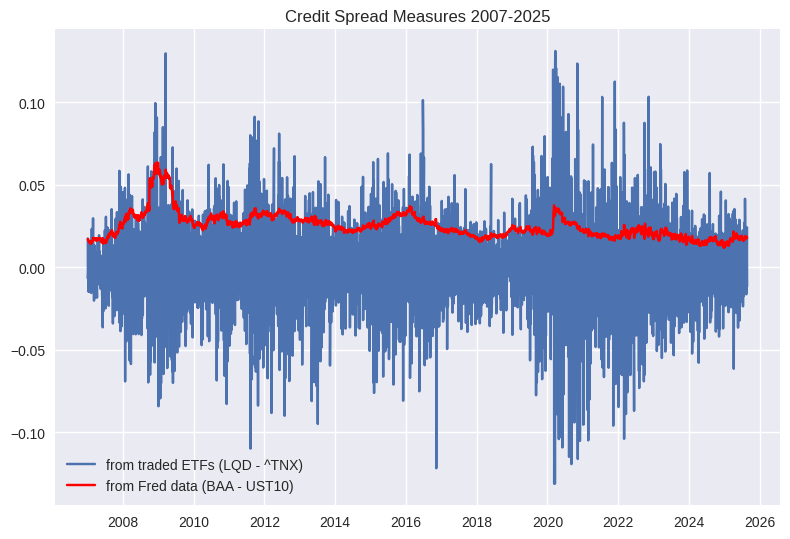

In [6]:
fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
plt.plot(spread_market.index, spread_market, label="from traded ETFs (LQD - ^TNX)") #, color='c')
plt.plot(spread_fred.index, spread_fred, color='r', label="from Fred data (BAA - UST10)")
plt.legend()
plt.title("Credit Spread Measures 2007-2025")
#spread_market.plot(ax=ax)
#spread_fred.plot(ax=ax, color='r')
plt.tight_layout()
plt.show()

In [34]:
def rolling_pca(returns, correlation_type, window=60):
    """
    correlation_type : str, choose among 'pearson', 'spearman' and 'kendall'
    returns : DataFrame (T×N) of zero‑mean daily returns
    returns, evr        : DataFrame indexed by window end‑date
    loadings_list       : list of Γ matrices (N×N) per window
    """

    evr_list, score_list, loadings_list = [], [], []
    idx = returns.index

    for t in range(window - 1, len(idx)):
        X = returns.iloc[t - window + 1 : t + 1]
        # C = np.corrcoef(X.T)                         # 11×11
        C = X.corr(method=correlation_type)
        vals, vecs = np.linalg.eigh(C)               # ascending

        # Sort descending and fix PC1 sign so XLK loading positive
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        if vecs[sector_tickers.index("XLK"), 0] < 0:
            vecs[:, 0] *= -1
        # Same procedure for PC2 & PC3 if desired (not necessary)

        evr_list.append(vals / vals.sum())
        loadings_list.append(vecs)
        score_list.append(vecs.T @ returns.iloc[t].values)

    dates = idx[window - 1 :]
    evr = pd.DataFrame(evr_list, index=dates,
                       columns=[f"EVR{k}" for k in range(1, len(returns.columns)+1)])
    scores = pd.DataFrame(score_list, index=dates,
                          columns=[f"PC{k}_score" for k in range(1, len(returns.columns)+1)])
    return evr, scores, loadings_list


evr, pcscores, _ = rolling_pca(sector_rets, 'pearson', window=60)

EVR1 = evr["EVR1"]
PC2_z = (pcscores["PC2_score"]
         .rolling(120).apply(lambda x: (x.iloc[-1] - x.mean()) / x.std(),
                             raw=False))
PC3_score = pcscores["PC3_score"]

vix = prices["^VIX"].loc[EVR1.index]
tnx = prices["^TNX"].loc[EVR1.index] / 100        # ^TNX quote is yield×100

<AxesSubplot: xlabel='Ticker', ylabel='Ticker'>

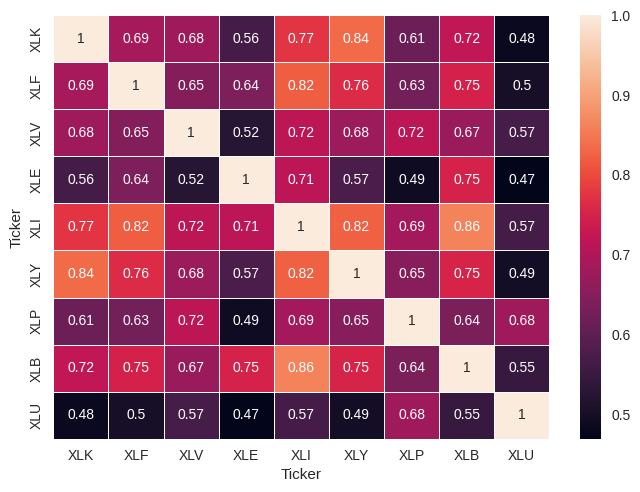

In [8]:
C_pearson = pd.DataFrame(np.corrcoef(sector_rets.T), index=sector_rets.columns, columns=sector_rets.columns)
sns.heatmap(C_pearson, annot=True, linewidth=.5)

<AxesSubplot: xlabel='Ticker', ylabel='Ticker'>

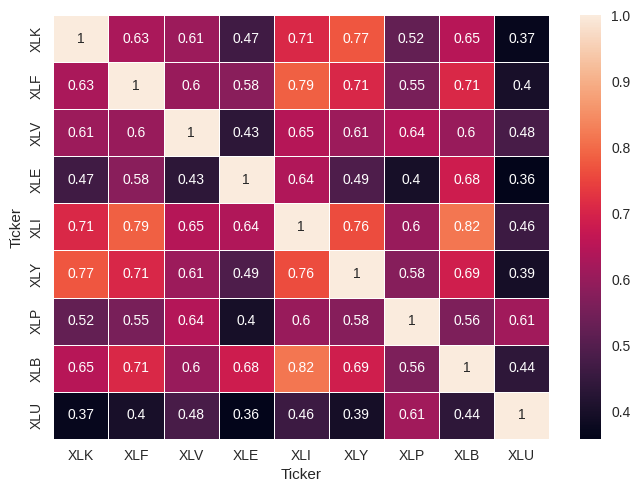

In [9]:
# spearman correlation
C_spearman = sector_rets.corr(method='spearman')
sns.heatmap(C_spearman, annot=True, linewidth=.5)

<AxesSubplot: xlabel='Ticker', ylabel='Ticker'>

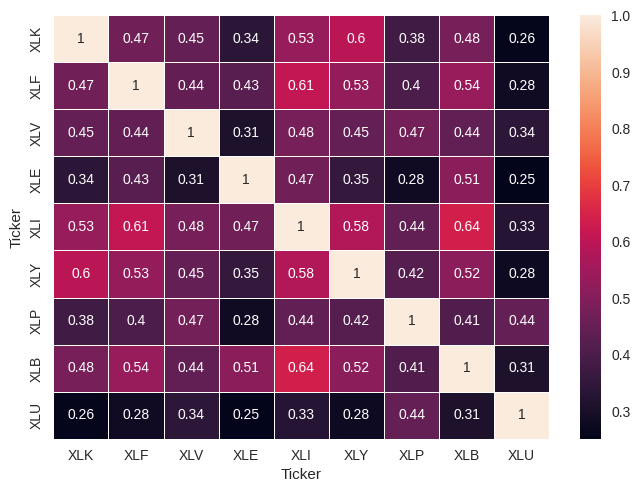

In [10]:
# kendall correlation
C_kendall = sector_rets.corr(method='kendall')
sns.heatmap(C_kendall, annot=True, linewidth=.5)

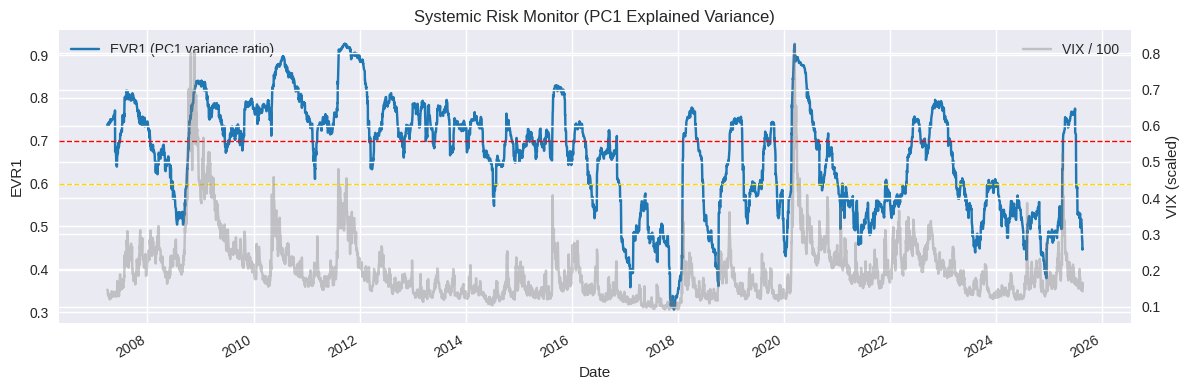

In [11]:
fig, ax1 = plt.subplots(figsize=(12,4))
EVR1.plot(ax=ax1, color="tab:blue", label="EVR1 (PC1 variance ratio)")
ax1.axhline(0.60, ls="--", color="gold", lw=1)
ax1.axhline(0.70, ls="--", color="red", lw=1)
ax1.set(ylabel="EVR1", title="Systemic Risk Monitor (PC1 Explained Variance)")
ax2 = ax1.twinx()
(vix/100).plot(ax=ax2, color="tab:gray", alpha=0.4, label="VIX / 100")
ax2.set_ylabel("VIX (scaled)")
ax1.legend(loc="upper left"); ax2.legend(loc="upper right")
plt.tight_layout()


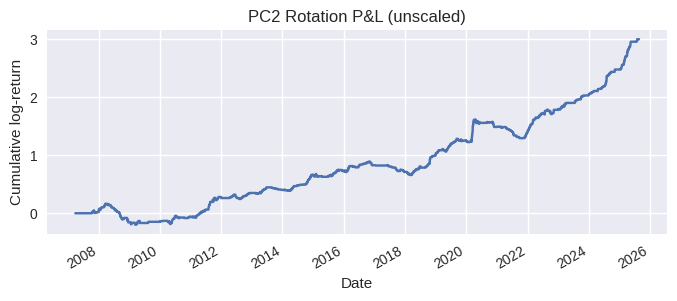

In [12]:
# 1. Trading signal: +1 = long‑cyclical, –1 = long‑defensive
signal = pd.Series(
    np.where(PC2_z < -1.5, -1,
    np.where(PC2_z >  1.5, 1, 0)),
    index=PC2_z.index
).fillna(0)                      # early NaNs → flat position

# 2. Cyclical and defensive legs
cyclical   = sector_rets[["XLK","XLY","XLE"]].mean(axis=1)
defensive  = sector_rets[["XLP","XLU","XLV"]].mean(axis=1)
spread     = cyclical - defensive

# 3. Align indices (inner join) and compute P&L
aligned = pd.concat([signal, spread], axis=1, join="inner").dropna()
rotation_pnl = (aligned.iloc[:,0] * aligned.iloc[:,1]).cumsum()

# 4. Plot
rotation_pnl.plot(figsize=(8,3),
                  title="PC2 Rotation P&L (unscaled)",
                  ylabel="Cumulative log-return")
plt.show()

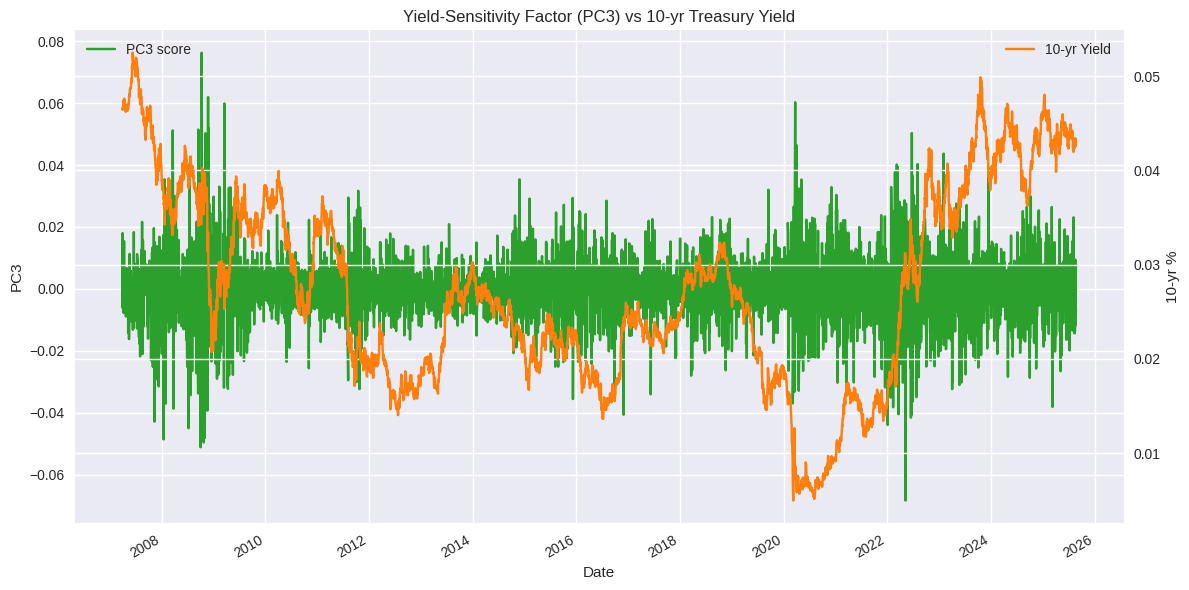

In [13]:
fig, ax1 = plt.subplots(figsize=(12,6))
PC3_score.plot(ax=ax1, color="tab:green", label="PC3 score")
ax1.set_ylabel("PC3")
ax2 = ax1.twinx()
tnx.plot(ax=ax2, color="tab:orange", label="10-yr Yield")
ax2.set_ylabel("10-yr %")
ax1.set_title("Yield-Sensitivity Factor (PC3) vs 10-yr Treasury Yield")
ax1.legend(loc="upper left"); ax2.legend(loc="upper right")
plt.tight_layout()


In [14]:
evr

,EVR1,EVR2,EVR3,EVR4,EVR5,EVR6,EVR7,EVR8,EVR9
Date,,,,,,,,,
2007-03-30,0.734296,0.080720,0.051433,0.036225,0.027841,0.020755,0.019804,0.019348,0.009577
2007-04-02,0.738875,0.077023,0.054117,0.032330,0.026783,0.022349,0.019607,0.017986,0.010929
2007-04-03,0.739954,0.077982,0.052211,0.032397,0.027068,0.022314,0.019699,0.017729,0.010647
2007-04-04,0.737339,0.077661,0.051974,0.032428,0.028363,0.022375,0.020841,0.018489,0.010531
2007-04-05,0.737516,0.076622,0.051976,0.032498,0.028446,0.023848,0.020837,0.018243,0.010015
...,...,...,...,...,...,...,...,...,...
2025-08-18,0.472952,0.137128,0.123500,0.077659,0.065427,0.038543,0.036443,0.030392,0.017955
2025-08-19,0.467197,0.144190,0.124468,0.078090,0.062985,0.038355,0.036645,0.030382,0.017689
2025-08-20,0.466849,0.140330,0.125821,0.077256,0.063150,0.039667,0.038226,0.030626,0.018076


In [15]:
# linear regression EVR vs credit spreads
Y = spread_market.loc["2007-03-30":]  # dependent variable (annual intensity)
X = evr[["EVR1", "EVR2", "EVR3"]]
X = sm.add_constant(X)   # intercept

ols = sm.OLS(Y, X).fit()
print(ols.summary())

                                OLS Regression Results                                
Dep. Variable:     Credit Spread from markets   R-squared:                       0.002
Model:                                    OLS   Adj. R-squared:                  0.001
Method:                         Least Squares   F-statistic:                     2.511
Date:                        Sun, 24 Aug 2025   Prob (F-statistic):             0.0568
Time:                                21:13:38   Log-Likelihood:                 10082.
No. Observations:                        4626   AIC:                        -2.016e+04
Df Residuals:                            4622   BIC:                        -2.013e+04
Df Model:                                   3                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

<AxesSubplot: xlabel='EVR1', ylabel='Credit Spread from markets'>

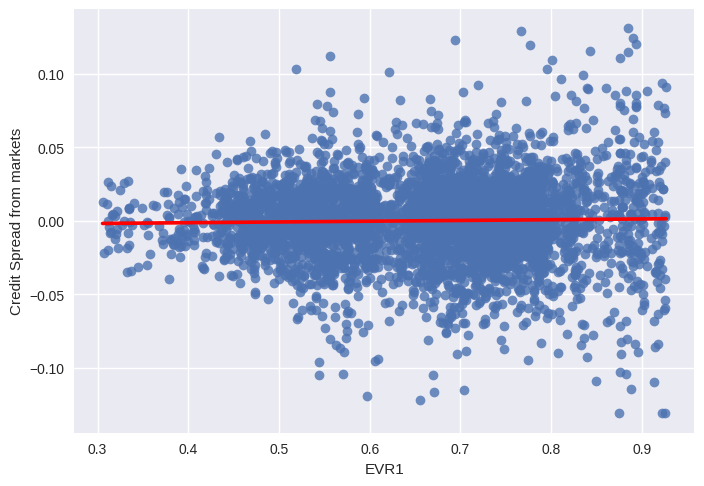

In [16]:
# plot regression
evr_spread_df = pd.concat([evr, spread_market], axis=1)
sns.regplot(x='EVR1', y='Credit Spread from markets', data=evr_spread_df, x_ci="ci", marker="o", scatter=True, line_kws=dict(color="r"), ci=None)

In [17]:
Y

,Credit Spread from markets
Date,
2007-03-30,-0.003821
2007-04-02,0.001872
2007-04-03,-0.005290
2007-04-04,0.003419
2007-04-05,-0.006779
...,...
2025-08-18,-0.004823
2025-08-19,0.010575
2025-08-20,0.001851


In [18]:
# linear regression pc scores vs credit spreads
Y = spread_market.loc["2007-03-30":]  # dependent variable (annual intensity)
X = pcscores[["PC1_score", "PC2_score", "PC3_score"]]
X = sm.add_constant(X)   # intercept

ols = sm.OLS(Y, X).fit()
print(ols.summary())

                                OLS Regression Results                                
Dep. Variable:     Credit Spread from markets   R-squared:                       0.079
Model:                                    OLS   Adj. R-squared:                  0.079
Method:                         Least Squares   F-statistic:                     132.4
Date:                        Sun, 24 Aug 2025   Prob (F-statistic):           2.61e-82
Time:                                21:13:39   Log-Likelihood:                 10269.
No. Observations:                        4626   AIC:                        -2.053e+04
Df Residuals:                            4622   BIC:                        -2.050e+04
Df Model:                                   3                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

<AxesSubplot: xlabel='PC1_score', ylabel='Credit Spread from markets'>

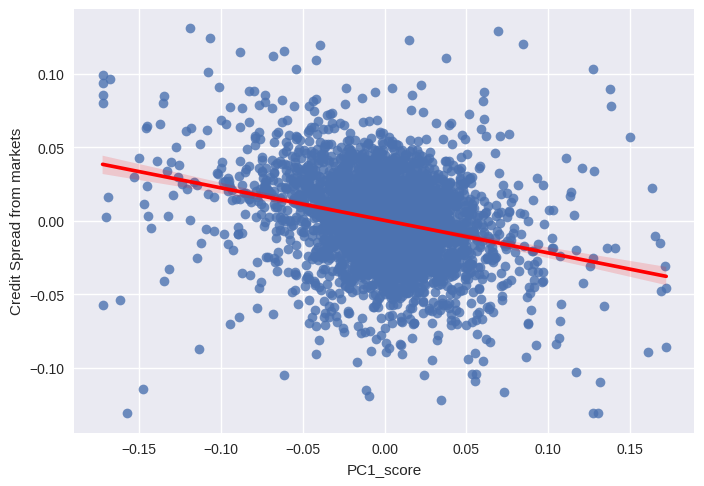

In [19]:
# plot regression (pc scores)
pcscores_spread_df = pd.concat([pcscores, spread_market], axis=1)
sns.regplot(x='PC1_score', y='Credit Spread from markets', data=pcscores_spread_df, x_ci="ci", marker="o", scatter=True, line_kws=dict(color="r"), ci=95)

In [20]:
pcscores

,PC1_score,PC2_score,PC3_score,PC4_score,PC5_score,PC6_score,PC7_score,PC8_score,PC9_score
Date,,,,,,,,,
2007-03-30,-0.004086,-0.014372,-0.005378,-0.005304,0.004336,0.003576,0.002526,-0.002932,-0.001138
2007-04-02,0.012242,0.013164,0.018009,0.005052,-0.003797,-0.007402,0.002137,0.002170,0.008089
2007-04-03,0.025711,0.002800,-0.006285,-0.001515,-0.004214,-0.001684,0.001478,-0.001712,0.000379
2007-04-04,0.002887,0.000968,-0.002986,-0.003983,-0.006425,0.004214,-0.005570,0.003568,-0.000263
2007-04-05,0.011206,-0.003159,-0.000841,-0.002616,0.002562,-0.006844,0.000320,-0.000375,0.003185
...,...,...,...,...,...,...,...,...,...
2025-08-18,-0.000770,0.002707,0.009423,0.002043,-0.002316,0.002169,-0.002344,-0.002975,-0.002580
2025-08-19,0.006326,-0.019525,-0.009960,0.001323,-0.002654,0.007889,0.000319,-0.000295,-0.001533
2025-08-20,0.000664,-0.005185,-0.011766,0.000708,0.003623,-0.009508,-0.003630,-0.003652,0.002707


In [21]:
spread_fred.loc["2007-03-30":]

,Credit Spread from FRED
Date,
2007-03-30,0.0162
2007-04-02,0.0174
2007-04-03,0.0172
2007-04-04,0.0173
2007-04-05,0.0171
...,...
2025-08-18,0.0176
2025-08-19,0.0180
2025-08-20,0.0181


In [22]:
evr

,EVR1,EVR2,EVR3,EVR4,EVR5,EVR6,EVR7,EVR8,EVR9
Date,,,,,,,,,
2007-03-30,0.734296,0.080720,0.051433,0.036225,0.027841,0.020755,0.019804,0.019348,0.009577
2007-04-02,0.738875,0.077023,0.054117,0.032330,0.026783,0.022349,0.019607,0.017986,0.010929
2007-04-03,0.739954,0.077982,0.052211,0.032397,0.027068,0.022314,0.019699,0.017729,0.010647
2007-04-04,0.737339,0.077661,0.051974,0.032428,0.028363,0.022375,0.020841,0.018489,0.010531
2007-04-05,0.737516,0.076622,0.051976,0.032498,0.028446,0.023848,0.020837,0.018243,0.010015
...,...,...,...,...,...,...,...,...,...
2025-08-18,0.472952,0.137128,0.123500,0.077659,0.065427,0.038543,0.036443,0.030392,0.017955
2025-08-19,0.467197,0.144190,0.124468,0.078090,0.062985,0.038355,0.036645,0.030382,0.017689
2025-08-20,0.466849,0.140330,0.125821,0.077256,0.063150,0.039667,0.038226,0.030626,0.018076


In [23]:
# linear regression EVR vs credit spreads
Y = spread_fred.loc["2007-03-30":].ffill()  # dependent variable (annual intensity)
X = evr[["EVR1", "EVR2", "EVR3"]]
X = sm.add_constant(X)   # intercept

ols_fred = sm.OLS(Y, X).fit()
print(ols_fred.summary())

                               OLS Regression Results                              
Dep. Variable:     Credit Spread from FRED   R-squared:                       0.290
Model:                                 OLS   Adj. R-squared:                  0.289
Method:                      Least Squares   F-statistic:                     628.0
Date:                     Sun, 24 Aug 2025   Prob (F-statistic):               0.00
Time:                             21:13:40   Log-Likelihood:                 16622.
No. Observations:                     4626   AIC:                        -3.324e+04
Df Residuals:                         4622   BIC:                        -3.321e+04
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

<AxesSubplot: xlabel='EVR1', ylabel='Credit Spread from FRED'>

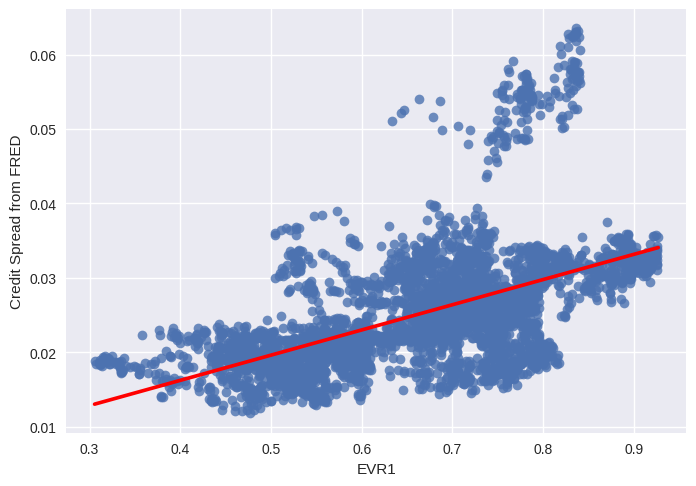

In [24]:
# plot regression
evr_spread_fred_df = pd.concat([evr, spread_fred], axis=1)
sns.regplot(x='EVR1', y='Credit Spread from FRED', data=evr_spread_fred_df, x_ci="ci", marker="o", scatter=True, line_kws=dict(color="r"), ci=None)

In [35]:
# eigendecomposition on rolling Spearman correlation matrix, then pick explained variance
evr_spearman, pcscores_spearman, _ = rolling_pca(sector_rets, "spearman", window=60)

EVR1 = evr_spearman["EVR1"]
PC2_z = (pcscores_spearman["PC2_score"]
         .rolling(120).apply(lambda x: (x.iloc[-1] - x.mean()) / x.std(),
                             raw=False))
PC3_score = pcscores_spearman["PC3_score"]

# vix = prices["^VIX"].loc[EVR1.index]
# tnx = prices["^TNX"].loc[EVR1.index] / 100        # ^TNX quote is yield×100

In [36]:
evr_spearman

,EVR1,EVR2,EVR3,EVR4,EVR5,EVR6,EVR7,EVR8,EVR9
Date,,,,,,,,,
2007-03-30,0.613870,0.107757,0.062161,0.059676,0.047867,0.034923,0.030560,0.026138,0.017046
2007-04-02,0.616815,0.106692,0.061961,0.053609,0.047725,0.039150,0.028866,0.026287,0.018895
2007-04-03,0.614818,0.107436,0.063372,0.054372,0.047864,0.038931,0.027921,0.026510,0.018777
2007-04-04,0.609976,0.106745,0.064435,0.057007,0.048102,0.038725,0.030079,0.026839,0.018093
2007-04-05,0.610935,0.104954,0.065066,0.057354,0.047920,0.041715,0.030295,0.026336,0.015426
...,...,...,...,...,...,...,...,...,...
2025-08-18,0.477128,0.133574,0.116925,0.077094,0.061073,0.045966,0.045134,0.030283,0.012823
2025-08-19,0.471984,0.140064,0.118370,0.077220,0.059104,0.046114,0.043934,0.030487,0.012723
2025-08-20,0.471428,0.134789,0.119887,0.076263,0.059524,0.049496,0.044440,0.030936,0.013236


In [37]:
# linear regression EVR (from Spearman corr) vs credit spreads
Y = spread_fred.loc["2007-03-30":].ffill()  # dependent variable (annual intensity)
X = evr_spearman[["EVR1", "EVR2", "EVR3"]]
X = sm.add_constant(X)   # intercept

ols_spearman = sm.OLS(Y, X).fit()
print(ols_spearman.summary())

                               OLS Regression Results                              
Dep. Variable:     Credit Spread from FRED   R-squared:                       0.338
Model:                                 OLS   Adj. R-squared:                  0.337
Method:                      Least Squares   F-statistic:                     785.8
Date:                     Sun, 24 Aug 2025   Prob (F-statistic):               0.00
Time:                             22:21:46   Log-Likelihood:                 16785.
No. Observations:                     4626   AIC:                        -3.356e+04
Df Residuals:                         4622   BIC:                        -3.354e+04
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

<AxesSubplot: xlabel='EVR1', ylabel='Credit Spread from FRED'>

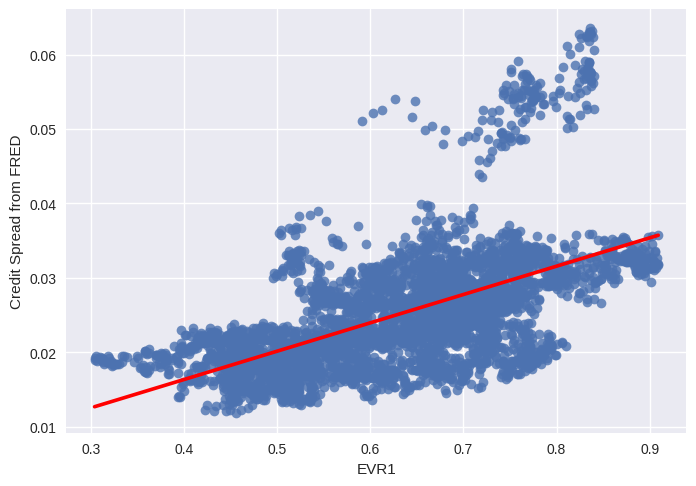

In [38]:
# plot regression
evr_spread_spearman_df = pd.concat([evr_spearman, spread_fred], axis=1)
sns.regplot(x='EVR1', y='Credit Spread from FRED', data=evr_spread_spearman_df, x_ci="ci", marker="o", scatter=True, line_kws=dict(color="r"), ci=None)